<a href="https://colab.research.google.com/github/tallwin/Forecasting-CocaCola/blob/main/CocaCola.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
coc=pd.read_excel("/content/CocaCola_Sales_Rawdata.xlsx")
coc.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [3]:
coc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


In [4]:
coc.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


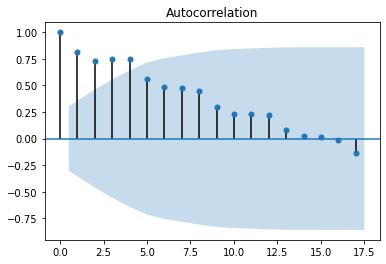

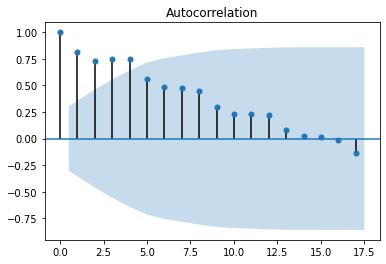

In [5]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(coc.Sales)

Building Time series forecasting with ARIMA

In [6]:
X = coc['Sales'].values

In [7]:
size = int (len (X) * 0.66 )

In [8]:
train, test = X[0:size], X[size:len(X)]

In [9]:
from statsmodels.tsa.arima_model import ARIMA

In [10]:
model = ARIMA(train, order=(5,1,0))

In [11]:
model_fit = model.fit(disp=0)

In [12]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   26
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -172.036
Method:                       css-mle   S.D. of innovations            163.191
Date:                Sat, 25 Dec 2021   AIC                            358.071
Time:                        13:08:26   BIC                            366.878
Sample:                             1   HQIC                           360.607
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.8442     26.509      1.579      0.130     -10.112      93.800
ar.L1.D.y     -0.1479      0.195     -0.758      0.457      -0.530       0.234
ar.L2.D.y     -0.3127      0.157     -1.996      0.0

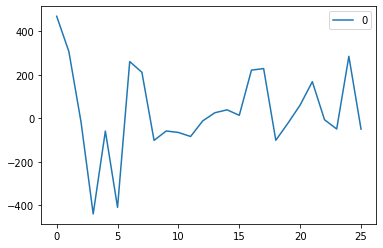

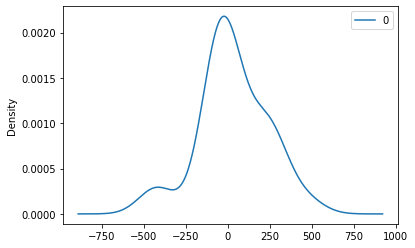

                0
count   26.000000
mean    31.324826
std    202.029892
min   -438.906974
25%    -58.604102
50%     -9.191391
75%    200.235195
max    468.289765


In [13]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

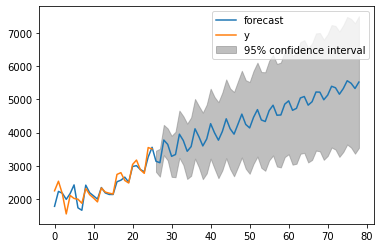

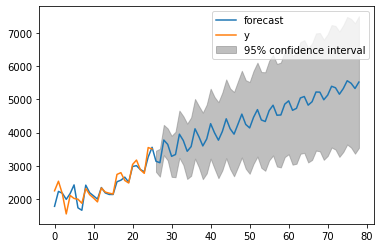

In [14]:
model_fit.plot_predict(1, 79)

Comparing Multiple Models

In [15]:
quarter=['Q1','Q2','Q3','Q4']
n=coc['Quarter'][0]
n[0:2]

'Q1'

In [16]:
coc['quarter']=0

In [17]:
for i in range(42):
    n=coc['Quarter'][i]
    coc['quarter'][i]=n[0:2]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [18]:
dummy=pd.DataFrame(pd.get_dummies(coc['quarter']))

In [19]:
coca=pd.concat((coc,dummy),axis=1)

In [20]:
t= np.arange(1,43)
coca['t']=t
coca['t_square']=coca['t']*coca['t']

In [21]:
log_Sales=np.log(coca['Sales'])
coca['log_Sales']=log_Sales

In [22]:
coca.head()

,Quarter,Sales,quarter,Q1,Q2,Q3,Q4,t,t_square,log_Sales
0,Q1_86,1734.827000,Q1,1,0,0,0,1,1,7.458663
1,Q2_86,2244.960999,Q2,0,1,0,0,2,4,7.716443
2,Q3_86,2533.804993,Q3,0,0,1,0,3,9,7.837477
3,Q4_86,2154.962997,Q4,0,0,0,1,4,16,7.675529
4,Q1_87,1547.818996,Q1,1,0,0,0,5,25,7.344602


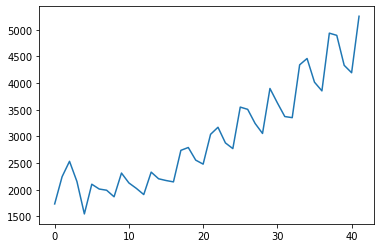

In [23]:
coca.Sales.plot()

In [24]:
#Train Test Split
train,test = np.split(coca, [int(.67 *len(coca))])

In [25]:
#linear model
linear= smf.ols('Sales~t',data=train).fit()
predlin=pd.Series(linear.predict(pd.DataFrame(test['t'])))
rmselin=np.sqrt((np.mean(np.array(test['Sales'])-np.array(predlin))**2))
rmselin

580.1224130918632

In [26]:
#quadratic model
quad=smf.ols('Sales~t+t_square',data=train).fit()
predquad=pd.Series(quad.predict(pd.DataFrame(test[['t','t_square']])))
rmsequad=np.sqrt(np.mean((np.array(test['Sales'])-np.array(predquad))**2))
rmsequad

783.729797503746

In [27]:
#exponential model
expo=smf.ols('log_Sales~t',data=train).fit()
predexp=pd.Series(expo.predict(pd.DataFrame(test['t'])))
predexp
rmseexpo=np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(predexp)))**2))
rmseexpo

588.1405104900199

In [28]:
#additive seasonality
additive= smf.ols('Sales~ Q1+Q2+Q3+Q4',data=train).fit()
predadd=pd.Series(additive.predict(pd.DataFrame(test[['Q1','Q2','Q3','Q4']])))
predadd
rmseadd=np.sqrt(np.mean((np.array(test['Sales'])-np.array(predadd))**2))
rmseadd

1770.0079170609727

In [29]:
#additive seasonality with linear trend
addlinear= smf.ols('Sales~t+Q1+Q2+Q3+Q4',data=train).fit()
predaddlinear=pd.Series(addlinear.predict(pd.DataFrame(test[['t','Q1','Q2','Q3','Q4']])))
rmseaddlinear=np.sqrt(np.mean((np.array(test['Sales'])-np.array(predaddlinear))**2))
rmseaddlinear

696.6333921288806

In [30]:
#additive seasonality with quadratic trend
addquad=smf.ols('Sales~t+t_square+Q1+Q2+Q3+Q4',data=train).fit()
predaddquad=pd.Series(addquad.predict(pd.DataFrame(test[['t','t_square','Q1','Q2','Q3','Q4']])))
rmseaddquad=np.sqrt(np.mean((np.array(test['Sales'])-np.array(predaddquad))**2))
rmseaddquad

707.7965578232494

In [31]:
#multiplicative seasonality
mulsea=smf.ols('log_Sales~Q1+Q2+Q3+Q4',data=train).fit()
predmul= pd.Series(mulsea.predict(pd.DataFrame(test[['Q1','Q2','Q3','Q4']])))
rmsemul= np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(predmul)))**2))
rmsemul

1809.6733570608103

In [32]:
#multiplicative seasonality with linear trend
mullin= smf.ols('log_Sales~t+Q1+Q2+Q3+Q4',data=train).fit()
predmullin= pd.Series(mullin.predict(pd.DataFrame(test[['t','Q1','Q2','Q3','Q4']])))
rmsemulin=np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(predmullin)))**2))
rmsemulin

492.5775596505526

In [33]:
#multiplicative seasonality with quadratic trend
mul_quad= smf.ols('log_Sales~t+t_square+Q1+Q2+Q3+Q4',data=train).fit()
pred_mul_quad= pd.Series(mul_quad.predict(test[['t','t_square','Q1','Q2','Q3','Q4']]))
rmse_mul_quad=np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(pred_mul_quad)))**2))
rmse_mul_quad

2015.374539562179

In [34]:
#tabulating the rmse values

data={'Model':pd.Series(['rmse_mul_quad','rmseadd','rmseaddlinear','rmseaddquad','rmseexpo','rmselin','rmsemul','rmsemulin','rmsequad']),
      'Values':pd.Series([rmse_mul_quad,rmseadd,rmseaddlinear,rmseaddquad,rmseexpo,rmselin,rmsemul,rmsemulin,rmsequad])}
Rmse=pd.DataFrame(data)
Rmse

,Model,Values
0,rmse_mul_quad,2015.374540
1,rmseadd,1770.007917
2,rmseaddlinear,696.633392
3,rmseaddquad,707.796558
4,rmseexpo,588.140510
5,rmselin,580.122413
6,rmsemul,1809.673357
7,rmsemulin,492.577560
8,rmsequad,783.729798


final model with least rmse value that is multiplicative seasonality with linear trend(mulin)